David Fleming 

#Bleeding Edge

#Below: General ICs to be filled in depending on system one considers

Ipython notebook for working with the evolution of a circumbinary disk.

Case: Kepler 38 modelled after the initial conditions of Kley+2014

General consideration: Disk initialized as if it sees star at origin (COM) with total mass of the binary system.
Binary stars then replace single star at origin with positions/velocities such that COM coincides with the origin and the binary system starts out at the periastron.

Initial CB disk conditions:

$\Sigma \sim r^{-1/2}$

$T \sim r^{-1}$

$T_0 = 750K \ at \ r_0 = 1au$ corresponding to typical values for minimum mass solar nebula

$m_{disk} = 0.0114886979929 M_{\odot}$

$\mu = 2.35$

$Q_{min} = 1.5$

$R_{disk} = R_{max} = 2.0 au$

$R_{in} = 0.25 au$

cutlength = 0.01

$n_{gas} = 1.0e+6, n_{points} = 5000 $

Initial Binary conditions:

$mass_{primary} = 0.949M_{\odot}$

$mass_{secondary} = 0.249M_{\odot}$

$a = 0.1469 au, \ e = 0.1032$

ChaNGa ICs:

dDelta = 0.00275(dDelta > 0.0023 found to be unstable...binary system flew off screen)

dEta = 0.1

dTheta = 0.7

nSteps = ?

For the rest, see the .param file

Contains basic code for anaylsis, plotting to be used later with my disks.

In [207]:
%matplotlib inline
#Imports required to run

import pynbody
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Imports from ICgen-Binary directory
import os
sys.path.append('/astro/users/dflemin3/Desktop/ICgen')
sys.path.append('/astro/users/dflemin3/Desktop')
import isaac
import AddBinary
import binaryUtils
import binary

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

In [208]:
#Change directory to where the data is
cwd = '/astro/users/dflemin3/Desktop'
os.chdir(cwd)

In [209]:
#Load Snapshot containing final conditions
s = pynbody.load('snapshot.std')

#Load initial conditions
s1 = pynbody.load('snapshot.std')

Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  snapshot.std
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  snapshot.std


In [210]:
#Make sure I have 2 stars in there with correct pos/vel
print s1.stars[0]['pos']
print s1.stars[1]['pos']

print s1.stars[0]['vel']
print s1.stars[1]['vel']

print s1.stars[0]['mass']
print s1.stars[1]['mass']

print
#Make sure I have 2 stars in there with correct pos/vel:
print s.stars[0]['pos']
print s.stars[1]['pos']

print s.stars[0]['vel']
print s.stars[1]['vel']

print s.stars[0]['mass']
print s.stars[1]['mass']

#Print current units
print s.stars[0]['pos'].units
print s.stars[0]['vel'].units

TipsySnap: loading data from main file
TipsySnap: loading data from main file

[[ 0.02738167  0.          0.        ]]
[[-0.10435825 -0.         -0.        ]]
[[-0.        0.658243  0.      ]]
[[ 0.        -2.5087254 -0.       ]]
[ 0.949]
[ 0.249]

[[ 0.02738167  0.          0.        ]]
[[-0.10435825 -0.         -0.        ]]
[[-0.        0.658243  0.      ]]
[[ 0.        -2.5087254 -0.       ]]
[ 0.949]
[ 0.249]
4.85e-09 kpc
2.98e+01 km s**-1


In [211]:
print np.sum(s.gas['mass'])
print s.gas['mass'].units

0.438554661741
Msol


In [212]:
print len(s.stars)
print len(s.gas)

2
100000


In [213]:
"""
Calculate changes in eccentricity, semimajor axis, stellar mass, and gas particle number over course of simulation.
"""

#Calculate Initial system parameters
x1 = s1.stars[0]['pos']
x2 = s1.stars[1]['pos']
v1 = s1.stars[0]['vel']
v2 = s1.stars[1]['vel']
m1 = s1.stars[0]['mass']
m2 = s1.stars[1]['mass']

ii = AddBinary.calcInc(x1, x2, v1, v2)

ei = AddBinary.calcEcc(x1, x2, v1, v2, m1, m2)

ai = AddBinary.calcSemi(x1, x2, v1, v2, m1, m2)
gi = len(s1.g)
mi = s1.stars['mass']

#Calculate final system parameters
x1 = s.stars[0]['pos']
x2 = s.stars[1]['pos']
v1 = s.stars[0]['vel']
v2 = s.stars[1]['vel']
m1 = s.stars[0]['mass']
m2 = s.stars[1]['mass']

ef = AddBinary.calcEcc(x1, x2, v1, v2, m1, m2)
af = AddBinary.calcSemi(x1, x2, v1, v2, m1, m2)
ifin = AddBinary.calcInc(x1, x2, v1, v2)
gf = len(s.g)
mf = s.stars['mass']

#Change in eccentricity
print "Initial eccentricity =",ei
print "Final eccentricity =",ef
print "Percent change in eccentricity = ",((ef-ei)/ei)*100
print ef-ei
print

#Change in semimajor axis
print "Initial semimajor axis =",ai
print "Final semimajor axis =",af
print "Percent change in semimajor axis = ",((af-ai)/ai)*100
print

#Change in inclination
print "Initial Inclination =", ii
print "Final Inclination =", ifin
print "Change in inclination = ",((ifin-ii))
print 

#Change in mass and # of gas particles eaten
print "Initial mass =",mi
print "Initial gas particles =",gi
print "Final mass =",mf
print "Final gas particles =",gf
print "Percent change in mass=",((mf-mi)/mi)*100
print "Change in gas particles =",(gf-gi)
print

Initial eccentricity = [ 0.10320005]
Final eccentricity = [ 0.10320005]
Percent change in eccentricity =  [ 0.]
[ 0.]

Initial semimajor axis = [ 0.14690001]
Final semimajor axis = [ 0.14690001]
Percent change in semimajor axis =  [ 0.]

Initial Inclination = [ 0.]
Final Inclination = [ 0.]
Change in inclination =  [ 0.]

Initial mass = [ 0.949  0.249]
Initial gas particles = 100000
Final mass = [ 0.949  0.249]
Final gas particles = 100000
Percent change in mass= [ 0.  0.]
Change in gas particles = 0



In [214]:
#Check CoM
#print "Binary center of mass = {0}".format(AddBinary.calcCOM(m1,m2,x1,x2))
sysCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True)
print "Current entire system center of mass = {0}".format(sysCom)
print "Magnitude of system center of mass = {0}".format(np.sqrt(AddBinary.dotProduct(sysCom,sysCom)))

Current entire system center of mass = [[  3.76460538e-04  -5.14889543e-04  -7.64165988e-05]]
Magnitude of system center of mass = [ 0.0006424]


Look at disk center of mass as a function of radius.  At each radius, only consider enclosed mass.

In [215]:
print s.stars['pos']
print s.stars['mass']
print s.stars['vel']
print s.stars['eps']

[[ 0.02738167  0.          0.        ]
 [-0.10435825 -0.         -0.        ]]
[ 0.949  0.249]
[[-0.         0.658243   0.       ]
 [ 0.        -2.5087254 -0.       ]]
[ 0.01924415  0.01924415]


In [216]:
m_disk = np.sum(s.gas['mass']) #add m_disk since s-type
e, a, i, Omega, w, nu = AddBinary.calcOrbitalElements(x1,x2,v1,v2,m1,m2)
M = AddBinary.calcMeanAnomaly(x1,x2,v1,v2,m1,m2)
print e, a, i, Omega, w, nu
print m1,m2

[ 0.10320005] [ 0.14690001] [ 0.] [ 0.] [ 0.] [ 0.]
[ 0.949] [ 0.249]


In [217]:
rCrit, error = AddBinary.calcCriticalRadius(a,e,mi[0],mi[1])

In [218]:
print 2.0*np.pi/AddBinary.calcCircularFrequency(x1,x2,v1,v2,m1,m2)

[ 15.19350595]


#Find inner disk edge
Following the prescription of Artymowics+1994, define the gap radius for a circumbinary disk to be at the disk edge position where the surface density is half of the maximum value in the disk.  In that paper, the gap size was studied for various binary eccentricities and mass ratios.  For Kepler 38, the mass ratio is 0.263 ~ 0.3 and the eccentricity is ~0.1.  These values correspond to a gap size of $r = 2.35 \pm 0.15$ times the binary semimajor axis.  For Kepler 38 whose a = 0.1469, one would expect to find after ~ 100 binary orbits a gap radius of ~0.34 au.  This gap formation occurs due to the tidal action of the binary system on the disk (and accretion where applicable).

The initial conditions of Artymowics+1994:

N_gas: ~ $10^4$
Disk Properties: axisymmetric; initialized with Keplerian velocities; $\Sigma \sim 1/r$; introduced binary into initially smooth disk (similar to my initialization).  For a binary with mass parameter $\mu = 0.3$ and eccentricity = 0.1, they found a gap at $r \approx 2.3a$ which is outside the 3:1 orbital period commensurability (Arty+1994 pg. 662).  


Note: In Kley+2014, they found that after ~2000yr of evolution, the inner edge of the disk to be $r \approx 0.45 au$ which corresponds to roughly $3a_{bin}$ which they claim is in good agreement with the results of Artymowics+1994.  The problem here is that Kley+2014 studied Kepler 38 where the mass ratio is about 0.3 and the eccentricity about 0.1.  The result that $r_{gap} \approx 3a_{bin}$ corresponds to a mass ratio of 0.3 and an eccentricity of 0.5 which does not hold for Kepler 38.


Below, I bin the disk surface density into radial bins and compute the radius at which the half maximum surface density occurs as described above.

In [219]:
#Create profile.  Note: Choose nbins to be the same number of n points ICgen-Binary used to initial generate disk
bins = 500
#pynbody.analysis.angmom.faceon(s.g)
#pynbody.analysis.halo.center(s.g,mode='hyb')

p = pynbody.analysis.profile.Profile(s,max='20 au',min='0.01 au',type='log',nbins=bins)
pg = pynbody.analysis.profile.Profile(s.gas,nbins=bins)

#Get arrays for surface density sigma, radius r
sigma = pg['density']
r = pg['rbins']

#Select subset of radial points within radius at which sigma = sigmaMax/2 (inner edge of disk)
max_index = np.argmax(sigma)
mask = (r < r[max_index])
sigma = sigma[mask]
r = r[mask]

#Find location of surface density maximum and look at radius r < r_max to find radius where surface density = max/2.0
halfMax = pg['density'].max()/2.0
#print "Half Max Surface Density = {0} {1}".format(halfMax,pg['density'].units)
    
crit_r = binaryUtils.find_crit_radius(r,sigma,halfMax,bins)
    
print "Inner gap edge radius = {0}".format(crit_r)

Profile: density()
Profile: mass()
Inner gap edge radius = 0.238648672853


#Examine radial profiles

4.85e-09 kpc
4.25e+16 Msol kpc**-2


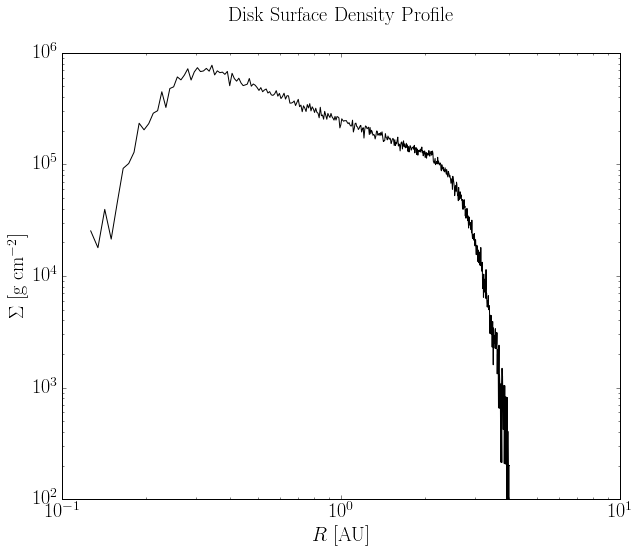

In [220]:
#Try plotting stuff
#Plot the gas surface density as a function of radius for test disk

#Now do the plotting with data derived from gas profile, pg
#In this case, tangential velocity vs. radius
plt.plot(pg['rbins'], pg['density'].in_units("g cm**-2"),'k')
plt.xlabel("$R$ [AU]")
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.yscale('log')
plt.title('Disk Surface Density Profile',y=1.06)
plt.xscale('log') #confirm radius powerlaw relation
#plt.xlim([0,5])

#Plot lines of interest
loc = 0.4644 #Radius of Kepler-38b
#print float(rCrit)
#plt.axvline(x=rCrit, ymin=-1, ymax = 1, linewidth=2, color='blue',label='$R_{critical}$ (Holman+1999)')
#plt.axvline(x=loc, ymin=-1, ymax = 1, linewidth=2, color='red',label="Kepler-38b Radius")
#plt.legend()

#Print units to confirm
print pg['rbins'].units
print pg['density'].units

#plt.savefig("sigmaVsR.png")

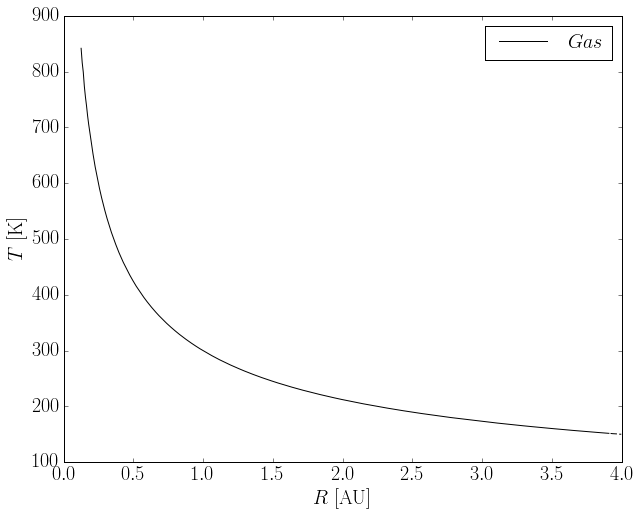

In [221]:
#Try plotting temperature profile of gas in plane of disk
#T vs. radius
plt.plot(pg['rbins'], pg['temp'],'k', label = '$Gas$')
plt.legend()
#plt.semilogy()
#plt.semilogx()
plt.xlabel("$R$ [AU]")
plt.ylabel("$T$ [K]")
plt.show()

#Check if disk is unstable to m = 1 perturbations as per Shu et al. 1990 eqn. 110

Profile: omega()
Profile: v_circ() -- warning, disk must be in the x-y plane
Rotation curve calculated in 0.104 s


SimSnap: deriving array rxy
SimSnap: deriving array rxy


(0, 10)

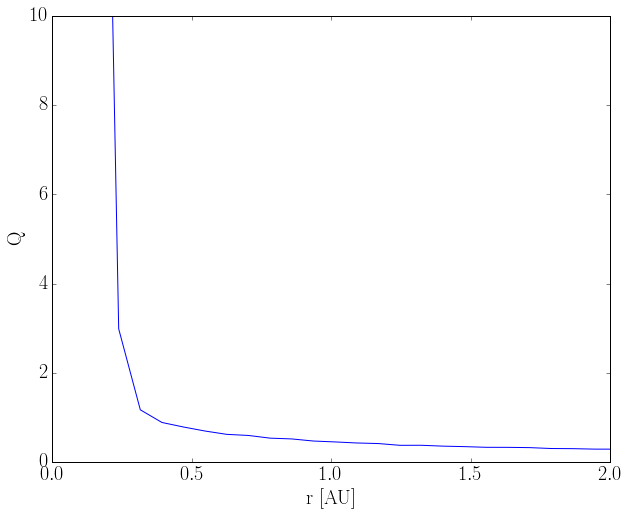

In [222]:
Mdisk = np.sum(s.gas['mass'])
mf = Mdisk/(Mdisk+np.sum(s.stars['mass']))
rd = 2.0

r_in = 1.0*a
r_out = rd
Qbins = 50
Q, rad =isaac.Q(s,2.35, bins=Qbins)
rad = (rad[1:] + rad[:-1])/2.0

plt.plot(rad,Q)
plt.ylabel("Q")
plt.xlabel("r [AU]")
plt.xlim(0,rd)
plt.ylim(0,10)

#plt.savefig("qVsRadius.pdf")

Profile: density()
Profile: mass()


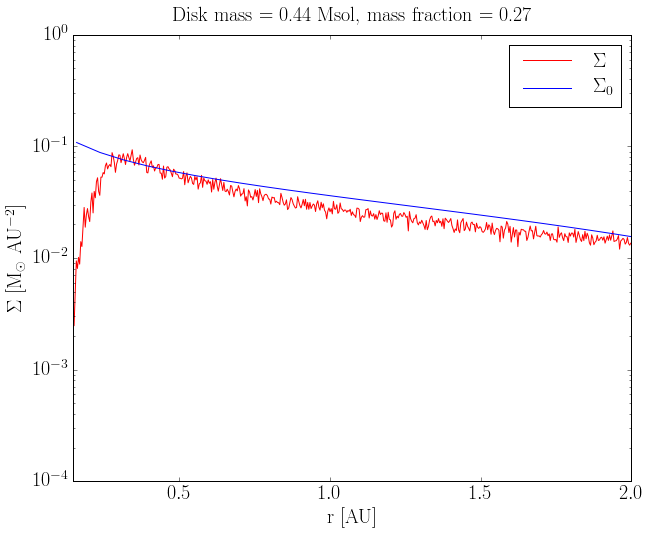

In [229]:
sigma0 = binaryUtils.calcStableSigma(rad,rd,np.sum(s.stars['mass']),Mdisk,1.0)
p = pynbody.analysis.profile.Profile(s.gas,max=r_out,min=r_in,nbins=bins)
sigma = p['density']
sigR = p['rbins']

plt.plot(sigR,sigma,color='red',label=r'$\Sigma$')
plt.plot(rad,sigma0,color='blue',label=r"$\Sigma_{0}$")
plt.xlim(0.15,rd)
#plt.ylim(0,0.001)
plt.legend(loc='upper right')
plt.semilogy()
plt.ylabel("$\Sigma$ [M$_{\odot}$ AU$^{-2}$]")
plt.xlabel("r [AU]")
plt.title("Disk mass = %0.2f Msol, mass fraction = %0.2f" % (Mdisk, mf),y=1.02)

#plt.savefig("shuInstability")

In [224]:
#Create nice color plot of temp as function of radius


#pynbody.analysis.angmom.faceon(s1.g)#create an image of gas density integrated
#down the line of site (z axis) of width 50 Au
sph.image(s.g,qty="rho",units="g cm^-2",width=1,cmap="Greys")

#Plot circle representing theoretical location of gap...should occur ~ 100 orbits
list_radians = [0]
 
# from degrees to radians, the 0 is already included so
# we don't make the universe collapse by dividing by zero.
for i in range(0,360):
    float_div = 180.0/(i+1)
    list_radians.append(pi/float_div)
     
# list of coordinates for each point
list_x2_axis = []
list_y2_axis = []

r = 2.3*ai #Inner gap edge predicted by Artimowicz+1994 for binary similar to Kepler 38
#r = 0.25
# calculate coordinates
# and append to above list
for a in list_radians:
    list_x2_axis.append(r*cos(a))
    list_y2_axis.append(r*sin(a))
    
#plot the coordinates
plt.plot(list_x2_axis,list_y2_axis,c='r')
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])

Rendering image on 4 threads...


SimSnap: deriving array smooth
Building 4 trees with leafsize=16
Tree build done in  0.05 s
Smoothing with 32 nearest neighbours
Smoothing done in 0.169s


ValueError: Failed to make a sensible logarithmic image. This probably means there are no particles in the view.

In [ ]:
#Create verticle profiles

#Create verticle gas profile object
p_vert = pynbody.analysis.profile.VerticalProfile(s.gas, '0 au', '20 au', '25 au') #(range_min,range_max,max)

#Now plot density vs distance
#Confirm density units are correct
p_vert['density'].convert_units('Msol au**-3')
print p_vert['density'].units
print p_vert['rbins'].units
plt.plot(p_vert['rbins'], p_vert['density'],'k', hold=False)
plt.xlabel('$z$ [Au]')
plt.ylabel(r'$\rho_{\star}$ [M$_{\odot}$ Au$^{-3}$]')
plt.yscale('log')

In [ ]:
#Plot temperature vs. distance from plane
#Looks terrible since data is for small number of particles
plt.plot(p_vert['rbins'], p_vert['temp'],'k', hold=False)
plt.xlabel('$z$ [Au]'); plt.ylabel('$T$ [K]')

In [ ]:
#Plot velocity vectors
f, axs = plt.subplots(1,1,figsize=(8,8))

#create a simple slice showing the gas temperature, with velocity vectors overlaid
sph.velocity_image(s.g, vector_color="cyan", qty="temp",width=10,cmap="YlOrRd",
                   denoise=True,approximate_fast=False, show_cbar = False)

#plt.savefig("vectors.pdf")